## Welcome and introduction
For this week's mini project, we're going to attempt the Kaggle 'Histopathologic Cancer Detection' competition.
This is a competition to create an algorithm that identifies metastatic cancer in small image patches taken from larger pathology scans.

This competition ran from Nov 16 2018 to Mar 31 2019, and it's available on [Kaggle](https://www.kaggle.com/c/histopathologic-cancer-detection).

For this project, we'll be utilizing a CNN Architecture and working to build a model that can detect cancerous images with a high degree of certainty.

We ran this on Google Colab, and fetched the dataset directly from kaggle.

We setup the images in the method described by [@vbookshelf](https://www.kaggle.com/code/vbookshelf/cnn-how-to-use-160-000-images-without-crashing)

To fetch the dataset, you will need to get a kaggle API key.

## Imports
Import all libraries used in this notebook

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import random
import tensorflow as tf
import shutil
import itertools
import zipfile
import time

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tqdm import tqdm


from PIL import Image, ImageOps, ImageEnhance
from google.colab import drive, files

## Fetch dataset
Fetch the data from Kaggle

In [ ]:
if not os.path.exists("kaggle.json"):
    files.upload()
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json


Saving kaggle.json to kaggle.json


Download the data

In [ ]:
!kaggle competitions download -c histopathologic-cancer-detection


100% 6.31G/6.31G [05:39<00:00, 23.4MB/s]
100% 6.31G/6.31G [05:39<00:00, 19.9MB/s]


In [ ]:
# List files in the dataset folder
dataset_path = './'
os.listdir(dataset_path)


['.config',
 'histopathologic-cancer-detection.zip',
 'kaggle.json',
 'sample_data']

In [ ]:
with zipfile.ZipFile("histopathologic-cancer-detection.zip", 'r') as zip_ref:
    zip_ref.extractall("dataset")

## Verify data
Some checks to confirm we've got the complete data

In [ ]:
print(len(os.listdir('dataset/train')))
print(len(os.listdir('dataset/test')))

220025
57458


In [ ]:
df_data = pd.read_csv('dataset/train_labels.csv')
print(df_data.columns)
print(df_data.shape)

Index(['id', 'label'], dtype='object')
(220025, 2)


## EDA
Let's explore and analyse the dataset to get a feel for its contents

In [ ]:
df_data['label'].value_counts()
print(df_data.head())
print("Null Values: ", df_data.isnull().sum())

                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0
Null Values:  id       0
label    0
dtype: int64


## Class Distribution
What's the distribution of Cancerous and Non-Cancerous images

label
0    130908
1     89117
Name: count, dtype: int64


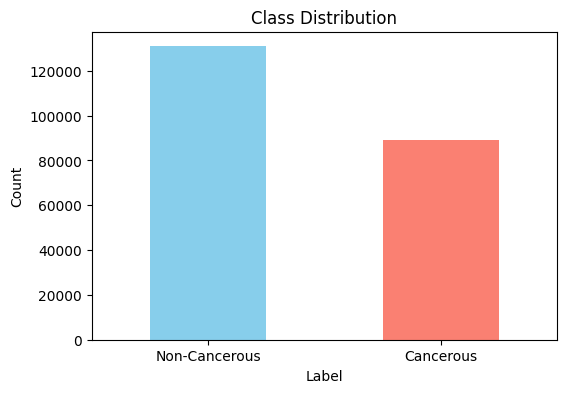

In [ ]:
print(df_data['label'].value_counts())
label_counts = df_data['label'].value_counts()

# Plot the distribution
plt.figure(figsize=(6, 4))
label_counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Class Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Non-Cancerous', 'Cancerous'], rotation=0)
plt.show()


## Image Properties
Let's check the image dimensions, channels and pixel intensity

Unique image dimensions: [[96 96]]
Unique channel counts: [3]


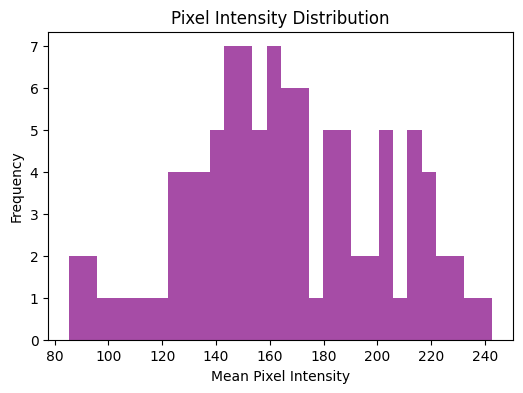

In [ ]:
# Directory containing the images
IMAGE_PATH = 'dataset/train/'

# Initialize lists to store image properties
dimensions = []
channels = []
pixel_means = []

# Sample a subset of images for analysis
sample_images = df_data['id'].sample(100).values

for img_id in sample_images:
    img_path = os.path.join(IMAGE_PATH, f'{img_id}.tif')
    with Image.open(img_path) as img:
        # Get image dimensions and number of channels
        dimensions.append(img.size)
        channels.append(len(img.getbands()))
        # Calculate mean pixel intensity
        pixel_means.append(np.array(img).mean())

# Convert lists to numpy arrays for analysis
dimensions = np.array(dimensions)
channels = np.array(channels)
pixel_means = np.array(pixel_means)

# Display unique dimensions and channel counts
print('Unique image dimensions:', np.unique(dimensions, axis=0))
print('Unique channel counts:', np.unique(channels))

# Plot pixel intensity distribution
plt.figure(figsize=(6, 4))
plt.hist(pixel_means, bins=30, color='purple', alpha=0.7)
plt.title('Pixel Intensity Distribution')
plt.xlabel('Mean Pixel Intensity')
plt.ylabel('Frequency')
plt.show()


## Visualize image
Let's sample a few images from each class

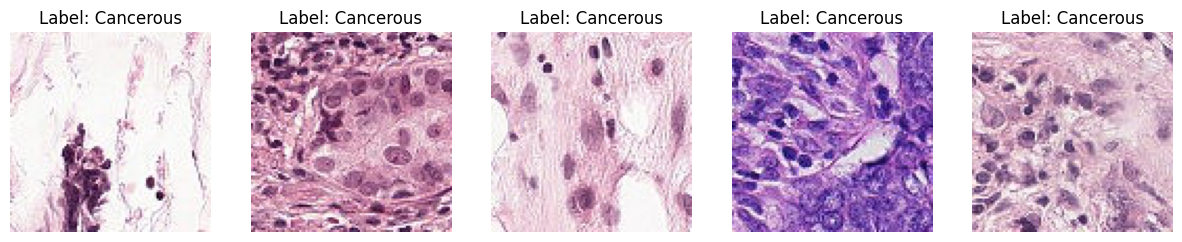

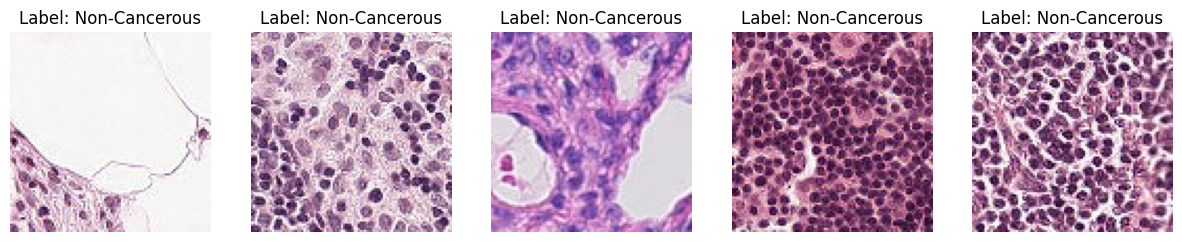

In [ ]:
# Function to display images
def display_images(image_ids, label, n=5):
    plt.figure(figsize=(15, 3))
    for i, img_id in enumerate(image_ids[:n]):
        img_path = os.path.join(IMAGE_PATH, f'{img_id}.tif')
        img = Image.open(img_path)
        plt.subplot(1, n, i + 1)
        plt.imshow(img)
        plt.title(f'Label: {label}')
        plt.axis('off')
    plt.show()

# Sample images for each class
cancerous_ids = df_data[df_data['label'] == 1]['id'].values
non_cancerous_ids = df_data[df_data['label'] == 0]['id'].values

# Display images
display_images(cancerous_ids, label='Cancerous')
display_images(non_cancerous_ids, label='Non-Cancerous')


## Search for duplicates
Here, we are going to read all images to ensure that there are no corrupted images, and also compute a hash to detect for duplicate images.

In [ ]:
# Function to compute image hash
def compute_image_hash(image_path):
    with Image.open(image_path) as img:
        return hash(img.tobytes())

# Dictionary to store hashes and corresponding image IDs
image_hashes = {}

# List to store duplicate image IDs
duplicates = []

# Iterate through all images
for img_id in tqdm(df_data['id'].values):
    img_path = os.path.join(IMAGE_PATH, f'{img_id}.tif')
    try:
        img_hash = compute_image_hash(img_path)
        if img_hash in image_hashes:
            duplicates.append(img_id)
        else:
            image_hashes[img_hash] = img_id
    except Exception as e:
        print(f'Error processing {img_id}: {e}')

# Display duplicates
print(f'Found {len(duplicates)} duplicate images.')


100%|██████████| 220025/220025 [01:59<00:00, 1836.63it/s]

Found 0 duplicate images.


## Preparation
Now that we have a good idea of the data, let's prepare the dataset for use.
We observed that there are over 120,000 Non-Cancerous images and about 84,000 Cancerous images. We're going to randomly pick 80,000 from images from each category for our dataset.

In [ ]:
IMAGE_SIZE = 96
SAMPLE_SIZE = 80000

In [ ]:
df_0 = df_data[df_data['label'] == 0].sample(SAMPLE_SIZE, random_state = 42)
df_1 = df_data[df_data['label'] == 1].sample(SAMPLE_SIZE, random_state = 42)

df_data = pd.concat([df_0, df_1], axis=0).reset_index(drop=True)
df_data = df_data.sample(frac=1, random_state=42).reset_index(drop=True)

print(df_data['label'].value_counts())

label
1    80000
0    80000
Name: count, dtype: int64


In [ ]:
print(df_data.head())
print(df_data.info())

                                         id  label
0  2ef40783fc281a49357c6bb14af4b28ea6341a09      1
1  1405cda9755325dba39e58e99c12318c3dec6b3f      0
2  223e200394d282a8093c6881ce12ff185be512a7      0
3  5089952f3c766732419e96d37fcf23ef2f5731d0      0
4  689591a3c8c36e16a1a03793c01a900a444f7263      1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160000 entries, 0 to 159999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      160000 non-null  object
 1   label   160000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB
None


## Train - Test Split
Split data into train and test sets

In [ ]:
y = df_data['label']

df_train, df_val = train_test_split(df_data, test_size=0.10, random_state=42, stratify=y)

print(df_train.shape)
print(df_val.shape)

(144000, 2)
(16000, 2)


In [ ]:
df_train['label'].value_counts()

,count
label,
0,72000
1,72000


Move our selected image files into new directories.
The new directory structure is
* base_dir
    - train_dir
        - a_no_tumor_tissue
        - b_has_tumor_tissue
    - val_dir
        - a_no_tumor_tissue
        - b_has_tumor_tissue




In [ ]:
# Create a new directory
base_dir = 'base_dir'
if(os.path.exists(base_dir)):
    shutil.rmtree(base_dir)
os.mkdir(base_dir)

train_dir = os.path.join(base_dir, 'train_dir')
os.mkdir(train_dir)

# val_dir
val_dir = os.path.join(base_dir, 'val_dir')
os.mkdir(val_dir)

# create new folders inside train_dir
no_tumor_tissue = os.path.join(train_dir, 'a_no_tumor_tissue')
os.mkdir(no_tumor_tissue)
has_tumor_tissue = os.path.join(train_dir, 'b_has_tumor_tissue')
os.mkdir(has_tumor_tissue)

# create new folders inside val_dir
no_tumor_tissue = os.path.join(val_dir, 'a_no_tumor_tissue')
os.mkdir(no_tumor_tissue)
has_tumor_tissue = os.path.join(val_dir, 'b_has_tumor_tissue')
os.mkdir(has_tumor_tissue)

In [ ]:
os.listdir('base_dir/train_dir')

['a_no_tumor_tissue', 'b_has_tumor_tissue']

## Performance
Set the 'id' column as an index for faster searching

In [ ]:
# Set the id as the index in df_data
df_data.set_index('id', inplace=True)

## Copy files
Let's copy the train and validation images into their respective folders

In [ ]:
train_list = list(df_train['id'])
val_list = list(df_val['id'])

for image in train_list:
    fname = image + '.tif'
    target = df_data.loc[image,'label']
    if target == 0:
        label = 'a_no_tumor_tissue'
    if target == 1:
        label = 'b_has_tumor_tissue'

    src = os.path.join('dataset/train', fname)
    dst = os.path.join(train_dir, label, fname)
    shutil.copyfile(src, dst)

for image in val_list:
    fname = image + '.tif'
    target = df_data.loc[image,'label']
    if target == 0:
        label = 'a_no_tumor_tissue'
    if target == 1:
        label = 'b_has_tumor_tissue'

    src = os.path.join('dataset/train', fname)
    dst = os.path.join(val_dir, label, fname)
    shutil.copyfile(src, dst)

Verify the image number in each folder

In [ ]:
print("Train (Non-Cancerous):", len(os.listdir('base_dir/train_dir/a_no_tumor_tissue')))
print("Train (Cancerous):", len(os.listdir('base_dir/train_dir/b_has_tumor_tissue')))
print("Val (Non-Cancerous):", len(os.listdir('base_dir/val_dir/a_no_tumor_tissue')))
print("Val (Cancerous):", len(os.listdir('base_dir/val_dir/b_has_tumor_tissue')))

Train (Non-Cancerous): 72000
Train (Cancerous): 72000
Val (Non-Cancerous): 8000
Val (Cancerous): 8000


## Prepare Image Generator for model
We're using Keras ImageDataGenerator to preprocess and load the images.
We rescale the image from the original range [0,255] to [0,1] for performance.
We also initialize three generators, Train, Validation and Test. Note that Validation and Test use the same images, so test is more of a mock/dummy test set.

In [ ]:
train_path = 'base_dir/train_dir'
valid_path = 'base_dir/val_dir'

num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = 10
val_batch_size = 10

train_steps = num_train_samples // train_batch_size
val_steps = num_val_samples // val_batch_size
epochs = 5

datagen = ImageDataGenerator(rescale=1.0/255)
train_gen = datagen.flow_from_directory(train_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=train_batch_size,
                                        class_mode='categorical')
val_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=val_batch_size,
                                        class_mode='categorical')
test_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=1,
                                        class_mode='categorical',
                                        shuffle=False)

Found 144000 images belonging to 2 classes.
Found 16000 images belonging to 2 classes.
Found 16000 images belonging to 2 classes.


## Model Architecture
Let's build a very simple model.
1. Conv2D Layer: Applies Convolution the image to get low-level features
    - 32: Number of feature maps to learn
    - (3, 3): Let's use a 3x3 grid
    - activation="relu": Apply ReLU to the output of the convulution
    - input_shape=(64, 64, 3)
2. BatchNormalization: Normalize the output of the previous layer
3. MaxPooling2D: Downsamples the feature maps
4. GlobalAveragePooling2D: Reduce number of parameters and prevent overfitting
5. Dense: Adds a dense layer with 32 neurons and ReLU
6. Dense: Output layer with final predictions

We expect this to work because we're beginning with a Convolution layer that is capturing a good number of features and using a small enough slide window that enables it capture a lot of information at each step. The next logical steps would be to tune by modifying the parameters for the convolution layer, and adding more layers to capture more areas of the image at a time.

In [ ]:
if os.path.exists("simplecnn.keras"):
    model = load_model("simplecnn.keras")
else :
    model = Sequential([
        Conv2D(32, (3, 3), activation="relu", input_shape=(64, 64, 3)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),

        GlobalAveragePooling2D(),

        Dense(32, activation="relu"),
        #Dropout(0.5),
        Dense(2, activation="softmax")  # Binary classification
    ])
    model.save("simplecnn.keras")

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 62, 62, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 62, 62, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 32)                  │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,146 (8.38 KB)

 Trainable params: 2,082 (8.13 KB)

 Non-trainable params: 64 (256.00 B)

In [ ]:
model.compile(Adam(learning_rate=0.0001), loss='binary_crossentropy',
              metrics=['accuracy'])

filepath = "simplecnn.keras"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1,
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=2,
                                   verbose=1, mode='max', min_lr=0.00001)


callbacks_list = [checkpoint, reduce_lr]

history = model.fit(train_gen,
                    steps_per_epoch=train_steps,
                    validation_data=val_gen,
                    validation_steps=val_steps,
                    epochs=epochs,
                    verbose=1,
                    callbacks=callbacks_list)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


14392/14400 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7629 - loss: 0.5176
Epoch 1: val_accuracy improved from -inf to 0.79819, saving model to simplecnn.keras
14400/14400 ━━━━━━━━━━━━━━━━━━━━ 133s 9ms/step - accuracy: 0.7629 - loss: 0.5176 - val_accuracy: 0.7982 - val_loss: 0.4406 - learning_rate: 1.0000e-04
Epoch 2/5
14400/14400 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 3/5
    8/14400 ━━━━━━━━━━━━━━━━━━━━ 1:50 8ms/step - accuracy: 0.7838 - loss: 0.5754  

/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/callback_list.py:96: UserWarning: Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)
/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_accuracy available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)
/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/callback_list.py:96: UserWarning: Learning rate reduction is conditioned on metric `val_acc` which is not available. Ava

14392/14400 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7961 - loss: 0.4457
Epoch 3: val_accuracy did not improve from 0.79819
14400/14400 ━━━━━━━━━━━━━━━━━━━━ 127s 9ms/step - accuracy: 0.7961 - loss: 0.4457 - val_accuracy: 0.7896 - val_loss: 0.4439 - learning_rate: 1.0000e-04
Epoch 4/5
14400/14400 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 5/5
14389/14400 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8020 - loss: 0.4316
Epoch 5: val_accuracy did not improve from 0.79819
14400/14400 ━━━━━━━━━━━━━━━━━━━━ 126s 9ms/step - accuracy: 0.8020 - loss: 0.4316 - val_accuracy: 0.7876 - val_loss: 0.4569 - learning_rate: 1.0000e-04


## Predictions on our local test data
Let's see how our model performs with our local test data

In [ ]:
predictions = model.predict(test_gen, steps=len(df_val), verbose=1)
df_preds = pd.DataFrame(predictions, columns=['no_tumor_tissue', 'has_tumor_tissue'])
df_preds.head()

y_true = test_gen.classes
y_pred = df_preds[['no_tumor_tissue', 'has_tumor_tissue']].values

16000/16000 ━━━━━━━━━━━━━━━━━━━━ 30s 2ms/step


In [ ]:
def plot_roc_curve(y_true, predictions, positive_class_index=1):
    """
    Compute and plot the ROC curve along with AUC score.

    Parameters:
    - y_true: Ground truth labels (list or array).
    - predictions: Model's predicted probabilities (2D array).
                   The second column (index=1) is assumed to hold positive class probabilities.
    - positive_class_index: Index of the positive class probabilities in predictions array (default=1).
    """
    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(y_true, predictions[:, positive_class_index])
    roc_auc = auc(fpr, tpr)

    # Print AUC Score
    print(f"ROC AUC Score: {roc_auc:.2f}")

    # Plot ROC Curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label="Random Guess")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic (ROC) Curve")
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

ROC AUC Score: 0.89


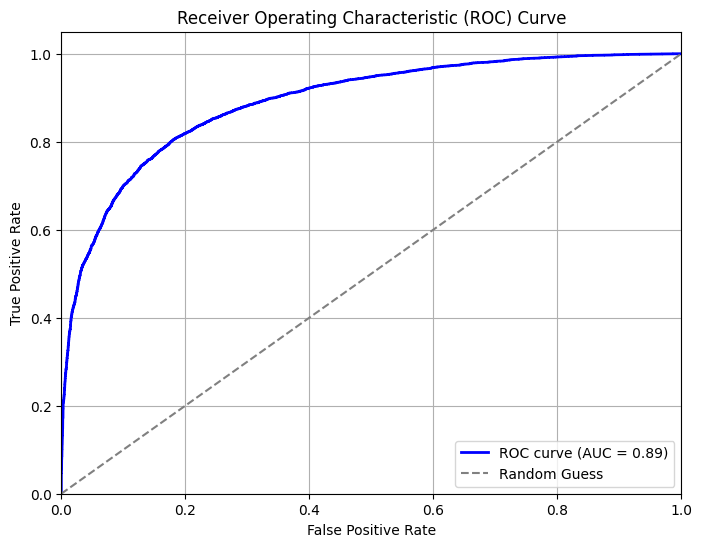

Confusion matrix, without normalization
[[5499 2501]
 [ 897 7103]]


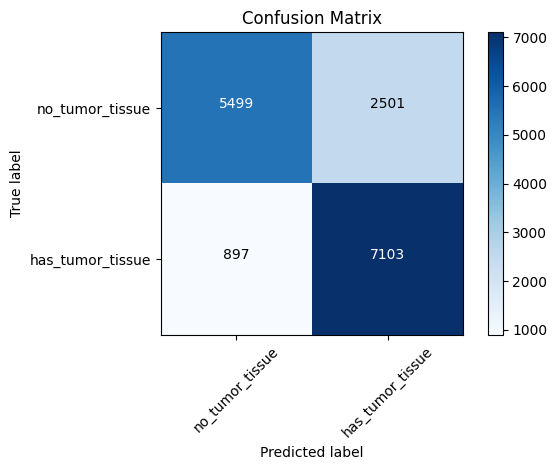

In [ ]:
plot_roc_curve(y_true, y_pred)

test_labels = test_gen.classes
test_labels.shape
test_gen.class_indices

cm = confusion_matrix(test_labels, predictions.argmax(axis=1))
cm_plot_labels = ['no_tumor_tissue', 'has_tumor_tissue']
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

In [ ]:
# Generate a classification report
y_pred_binary = predictions.argmax(axis=1)
report = classification_report(y_true, y_pred_binary, target_names=cm_plot_labels)

print(report)

                  precision    recall  f1-score   support

 no_tumor_tissue       0.86      0.69      0.76      8000
has_tumor_tissue       0.74      0.89      0.81      8000

        accuracy                           0.79     16000
       macro avg       0.80      0.79      0.79     16000
    weighted avg       0.80      0.79      0.79     16000



## Tune hyperparameters
Let's use a model architecture that has multiple convolutions layers, and let's loop through some hyperparameters.


Training with learning_rate=0.001, batch_size=32, epochs=5
Epoch 1/5
447/450 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5121 - loss: 0.8215
Epoch 1: val_accuracy improved from -inf to 0.51200, saving model to best_model.keras
450/450 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.5122 - loss: 0.8206 - val_accuracy: 0.5120 - val_loss: 0.6930 - learning_rate: 0.0010
Epoch 2/5
444/450 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5218 - loss: 0.6920
Epoch 2: val_accuracy did not improve from 0.51200
450/450 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.5220 - loss: 0.6920 - val_accuracy: 0.4800 - val_loss: 0.6970 - learning_rate: 0.0010
Epoch 3/5
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5209 - loss: 0.6916
Epoch 3: val_accuracy improved from 0.51200 to 0.59800, saving model to best_model.keras
450/450 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.5209 - loss: 0.6916 - val_accuracy: 0.5980 - val_loss: 0.6757 - learning_rate: 0.0010
Epoch 4/5
444/450 ━━━━━━━━━━━━━━━

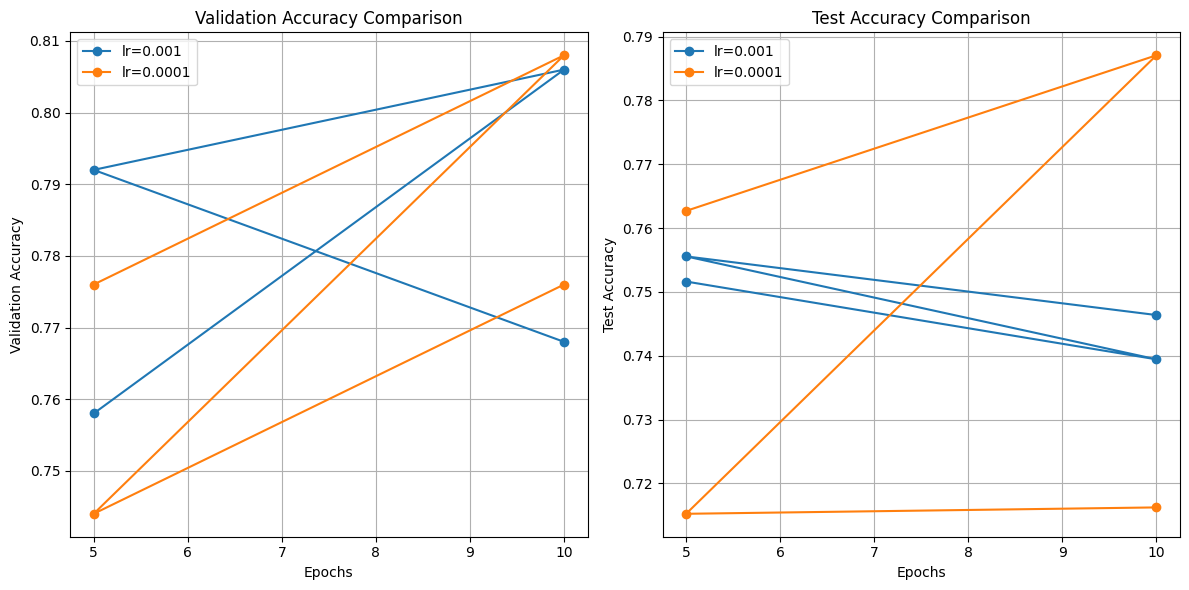


Best Performing Configurations:
   learning_rate  batch_size  epochs  val_accuracy  test_accuracy
5         0.0001          32      10         0.808       0.787063
4         0.0001          32       5         0.776       0.762688
2         0.0010          64       5         0.792       0.755562
0         0.0010          32       5         0.758       0.751625
3         0.0010          64      10         0.768       0.746375


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import accuracy_score

# Hyperparameter combinations
learning_rates = [0.001, 0.0001]
batch_sizes = [32, 64]
num_epochs = [5, 10]

# Store results for comparison
results_tuning = []

# Model Building Function
def build_model():
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(2, activation='softmax')
    ])
    return model

# Loop through hyperparameter combinations
for lr in learning_rates:
    for batch_size in batch_sizes:
        for epochs in num_epochs:
            print(f"\nTraining with learning_rate={lr}, batch_size={batch_size}, epochs={epochs}")

            # Build and compile the model
            model = build_model()
            model.compile(Adam(learning_rate=lr), loss='binary_crossentropy', metrics=['accuracy'])

            # Callbacks
            checkpoint = ModelCheckpoint("best_model.keras", monitor='val_accuracy', verbose=1,
                                         save_best_only=True, mode='max')
            reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2,
                                          verbose=1, mode='max', min_lr=0.00001)
            callbacks_list = [checkpoint, reduce_lr]

            # Fit the model
            history = model.fit(train_gen,
                                steps_per_epoch=train_steps // batch_size,
                                validation_data=val_gen,
                                validation_steps=val_steps // batch_size,
                                epochs=epochs,
                                verbose=1,
                                callbacks=callbacks_list)

            # Evaluate on test_gen
            test_accuracy = model.evaluate(test_gen, verbose=0)[1]

            # Store results
            results_tuning.append({
                'learning_rate': lr,
                'batch_size': batch_size,
                'epochs': epochs,
                'val_accuracy': max(history.history['val_accuracy']),
                'test_accuracy': test_accuracy
            })
            print(f"Test Accuracy: {test_accuracy:.4f}")

# Convert results to DataFrame
results_df_tuning = pd.DataFrame(results_tuning)

# Visualization of Results
plt.figure(figsize=(12, 6))

# Compare Validation Accuracy
plt.subplot(1, 2, 1)
for lr in learning_rates:
    subset = results_df_tuning[results_df_tuning['learning_rate'] == lr]
    plt.plot(subset['epochs'], subset['val_accuracy'], marker='o', label=f'lr={lr}')
plt.title("Validation Accuracy Comparison")
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.legend()
plt.grid()

# Compare Test Accuracy
plt.subplot(1, 2, 2)
for lr in learning_rates:
    subset = results_df_tuning[results_df_tuning['learning_rate'] == lr]
    plt.plot(subset['epochs'], subset['test_accuracy'], marker='o', label=f'lr={lr}')
plt.title("Test Accuracy Comparison")
plt.xlabel("Epochs")
plt.ylabel("Test Accuracy")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

# Display the best results
print("\nBest Performing Configurations:")
print(results_df_tuning.sort_values(by='test_accuracy', ascending=False).head())


## Another Architecture
Let's try a more complex architecture
This is modeled after the kernel developed by @fmarazzi and his process is available on [kaggle](https://www.kaggle.com/code/fmarazzi/baseline-keras-cnn-roc-fast-10min-0-925-lb/notebook?scriptVersionId=7784920)
This architecture is similar to the VGGNet architecture described in class, with multiple convolution layers and a pooling layer. This architecture s dividedo three major blocks, with each block containing three Convolution layers with the same sizes, e.g 32 for the first block, 64 for the second, and 128 for the third. We expect this kernel to perform better than our Simple convolution and pooling layer above.

In [ ]:
# Model Parameters
first_filters = 32
second_filters = 64
third_filters = 128
kernel_size = (3, 3)
pool_size = (2, 2)
dropout_conv = 0.25
dropout_dense = 0.5

# Build the model using the Sequential() constructor
advanced_model = Sequential([
    # First block
    Conv2D(first_filters, kernel_size, activation='relu', input_shape=(96, 96, 3)),
    Conv2D(first_filters, kernel_size, activation='relu'),
    Conv2D(first_filters, kernel_size, activation='relu'),
    MaxPooling2D(pool_size=pool_size),
    Dropout(dropout_conv),

    # Second block
    Conv2D(second_filters, kernel_size, activation='relu'),
    Conv2D(second_filters, kernel_size, activation='relu'),
    Conv2D(second_filters, kernel_size, activation='relu'),
    MaxPooling2D(pool_size=pool_size),
    Dropout(dropout_conv),

    # Third block
    Conv2D(third_filters, kernel_size, activation='relu'),
    Conv2D(third_filters, kernel_size, activation='relu'),
    Conv2D(third_filters, kernel_size, activation='relu'),
    MaxPooling2D(pool_size=pool_size),
    Dropout(dropout_conv),

    # Fully connected layers
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(dropout_dense),
    Dense(2, activation='softmax')  # Final output layer with 2 classes
])

# Model summary
advanced_model.summary()
advanced_model.compile(Adam(learning_rate=0.0001), loss='binary_crossentropy',
              metrics=['accuracy'])

history = advanced_model.fit(train_gen,
                    steps_per_epoch=train_steps,
                    validation_data=val_gen,
                    validation_steps=val_steps,
                    epochs=epochs,
                    verbose=1)

# make a prediction
advanced_predictions = advanced_model.predict(test_gen, steps=len(df_val), verbose=1)
advanced_df_preds = pd.DataFrame(advanced_predictions, columns=['no_tumor_tissue', 'has_tumor_tissue'])



/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_19 (Conv2D)                   │ (None, 94, 94, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (None, 92, 92, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 90, 90, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_27 (Dropout)                 │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 43, 43, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 41, 41, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_24 (Conv2D)                   │ (None, 39, 39, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_20 (MaxPooling2D)      │ (None, 19, 19, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_28 (Dropout)                 │ (None, 19, 19, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 17, 17, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_26 (Conv2D)                   │ (None, 15, 15, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_27 (Conv2D)                   │ (None, 13, 13, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_21 (MaxPooling2D)      │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_29 (Dropout)                 │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_9 (Flatten)                  │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 256)                 │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_30 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,661,186 (6.34 MB)

 Trainable params: 1,661,186 (6.34 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
14400/14400 ━━━━━━━━━━━━━━━━━━━━ 139s 9ms/step - accuracy: 0.7497 - loss: 0.4985 - val_accuracy: 0.8279 - val_loss: 0.3909
Epoch 2/10
14400/14400 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/10
    7/14400 ━━━━━━━━━━━━━━━━━━━━ 2:03 9ms/step - accuracy: 0.8685 - loss: 0.2550  

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


14400/14400 ━━━━━━━━━━━━━━━━━━━━ 131s 9ms/step - accuracy: 0.8473 - loss: 0.3547 - val_accuracy: 0.8769 - val_loss: 0.2923
Epoch 4/10
14400/14400 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/10
14400/14400 ━━━━━━━━━━━━━━━━━━━━ 130s 9ms/step - accuracy: 0.8736 - loss: 0.3029 - val_accuracy: 0.8861 - val_loss: 0.2849
Epoch 6/10
14400/14400 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 7/10
14400/14400 ━━━━━━━━━━━━━━━━━━━━ 130s 9ms/step - accuracy: 0.8885 - loss: 0.2734 - val_accuracy: 0.8936 - val_loss: 0.2593
Epoch 8/10
14400/14400 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 9/10
14400/14400 ━━━━━━━━━━━━━━━━━━━━ 131s 9ms/step - accuracy: 0.8993 - loss: 0.2494 - val_accuracy: 0.9107 - val_loss: 0.2236
Epoch 10/10
14400/14400 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
16000/16000 ━━━━━━━━━━━━━━━━━━━━ 32s 2ms/step


ROC AUC Score: 0.97


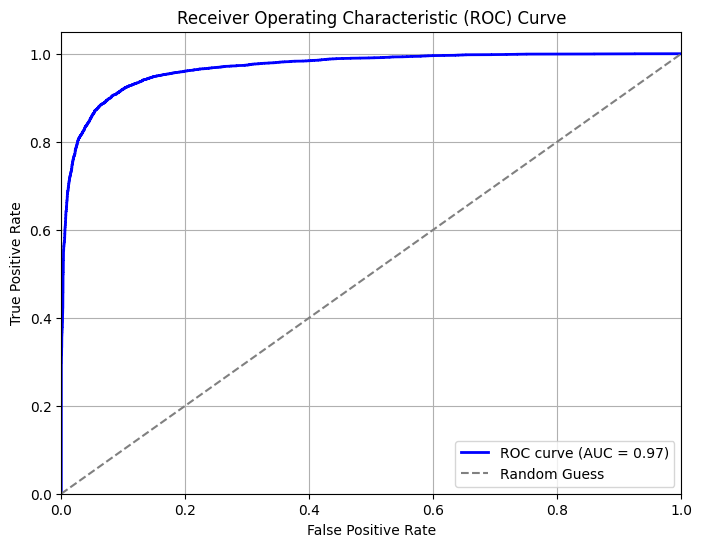

Confusion matrix, without normalization
[[5499 2501]
 [ 897 7103]]


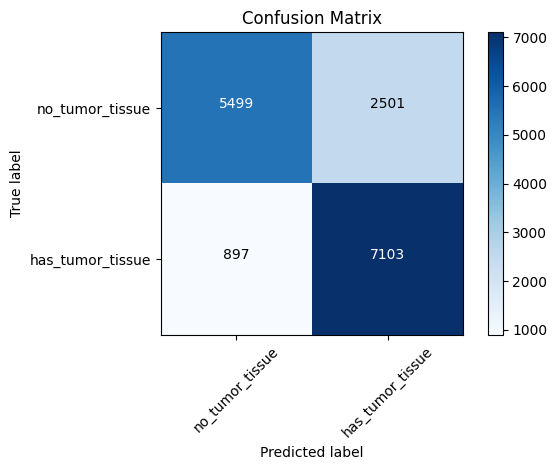

In [ ]:
advanced_df_preds.head()
advanced_y_true = test_gen.classes

# Get the predicted labels as probabilities
#advanced_y_pred = advanced_df_preds['has_tumor_tissue']
advanced_y_pred = advanced_df_preds[['no_tumor_tissue', 'has_tumor_tissue']].values
plot_roc_curve(advanced_y_true, advanced_y_pred)

advanced_test_labels = test_gen.classes
#advanced_test_labels.shape
#test_gen.class_indices

advanced_cm = confusion_matrix(test_labels, predictions.argmax(axis=1))
advanced_cm_plot_labels = ['no_tumor_tissue', 'has_tumor_tissue']
plot_confusion_matrix(advanced_cm, advanced_cm_plot_labels, title='Confusion Matrix')

## Compare Simple vs Advanced
Let's write some code to compare the simple kernel vs the advanced.
Over the next couple of cells, we'll create some functions to show visualizations comparing the results of both architectures, and then we'll run both models on the same data with the same parameters.

In [ ]:
def plot_accuracy(history1, history2, model1_name, model2_name):
    plt.figure(figsize=(10, 6))

    # Plot accuracy for Model 1
    plt.plot(history1.history['accuracy'], label=f"{model1_name} Train Accuracy", linestyle='--')
    plt.plot(history1.history['val_accuracy'], label=f"{model1_name} Val Accuracy")

    # Plot accuracy for Model 2
    plt.plot(history2.history['accuracy'], label=f"{model2_name} Train Accuracy", linestyle='--')
    plt.plot(history2.history['val_accuracy'], label=f"{model2_name} Val Accuracy")

    plt.title("Training and Validation Accuracy Comparison")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid()
    plt.show()


In [ ]:
def plot_loss(history1, history2, model1_name, model2_name):
    plt.figure(figsize=(10, 6))

    # Plot loss for Model 1
    plt.plot(history1.history['loss'], label=f"{model1_name} Train Loss", linestyle='--')
    plt.plot(history1.history['val_loss'], label=f"{model1_name} Val Loss")

    # Plot loss for Model 2
    plt.plot(history2.history['loss'], label=f"{model2_name} Train Loss", linestyle='--')
    plt.plot(history2.history['val_loss'], label=f"{model2_name} Val Loss")

    plt.title("Training and Validation Loss Comparison")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()
    plt.show()


In [ ]:
def plot_roc_curve(model1_preds, model2_preds, y_true, model1_name, model2_name):
    fpr1, tpr1, _ = roc_curve(y_true, model1_preds)
    fpr2, tpr2, _ = roc_curve(y_true, model2_preds)

    auc1 = auc(fpr1, tpr1)
    auc2 = auc(fpr2, tpr2)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr1, tpr1, label=f"{model1_name} (AUC = {auc1:.2f})")
    plt.plot(fpr2, tpr2, label=f"{model2_name} (AUC = {auc2:.2f})")
    plt.plot([0, 1], [0, 1], 'k--', label="Random Guess (AUC = 0.50)")

    plt.title("ROC Curve Comparison")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.grid()
    plt.show()


In [ ]:
def plot_confusion_matrix(y_true, y_pred1, y_pred2, model1_name, model2_name):
    cm1 = confusion_matrix(y_true, y_pred1)
    cm2 = confusion_matrix(y_true, y_pred2)

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Model 1 Confusion Matrix
    sns.heatmap(cm1, annot=True, fmt="d", cmap="Blues", ax=axes[0])
    axes[0].set_title(f"{model1_name} Confusion Matrix")
    axes[0].set_xlabel("Predicted")
    axes[0].set_ylabel("Actual")

    # Model 2 Confusion Matrix
    sns.heatmap(cm2, annot=True, fmt="d", cmap="Greens", ax=axes[1])
    axes[1].set_title(f"{model2_name} Confusion Matrix")
    axes[1].set_xlabel("Predicted")
    axes[1].set_ylabel("Actual")

    plt.tight_layout()
    plt.show()


In [ ]:
def compare_model_parameters(model1, model2, model1_name, model2_name):
    print(f"{model1_name} Trainable Parameters: {model1.count_params():,}")
    print(f"{model2_name} Trainable Parameters: {model2.count_params():,}")


In [ ]:
def visualize_predictions(images, labels, preds1, preds2, model1_name, model2_name):
    plt.figure(figsize=(12, 8))
    for i in range(6):
        plt.subplot(2, 3, i + 1)
        plt.imshow(images[i])
        title = f"True: {labels[i]}\n{model1_name}: {preds1[i]}\n{model2_name}: {preds2[i]}"
        plt.title(title)
        plt.axis("off")
    plt.tight_layout()
    plt.show()


In [ ]:
def evaluate_model(model, train_generator, val_generator, test_generator, epochs=10):
    """
    Trains the model, generates metrics, and computes time for training and prediction.

    Parameters:
    - model: Keras model to evaluate
    - train_generator: Training data generator
    - val_generator: Validation data generator
    - test_generator: Test data generator
    - epochs: Number of epochs to train

    Returns:
    - history: Training history object
    - y_true: True labels for test data
    - y_pred: Predicted labels (argmax)
    - y_pred_proba: Predicted probabilities for test data
    - cm: Confusion matrix
    - roc_data: FPR, TPR, and AUC for ROC curve
    - train_time: Time taken to fit the model
    - predict_time: Time taken to predict on test data
    """
    # 1. Train the model and calculate training time
    start_time = time.time()
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=epochs,
        verbose=1
    )
    train_time = time.time() - start_time

    # 2. Predict on test data and calculate prediction time
    start_time = time.time()
    y_pred_proba = model.predict(test_generator, verbose=1)
    predict_time = time.time() - start_time

    # Convert predicted probabilities to class labels (argmax)
    y_pred = np.argmax(y_pred_proba, axis=1)

    # 3. Get true labels from test generator
    y_true = test_generator.classes

    # 4. Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)

    # 5. ROC Curve Data
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba[:, 1])
    roc_auc = tf.keras.metrics.AUC()(y_true, y_pred_proba[:, 1]).numpy()
    roc_data = (fpr, tpr, roc_auc)

    # 6. Print Summary Statistics
    print(f"\nTraining Time: {train_time:.2f} seconds")
    print(f"Prediction Time: {predict_time:.2f} seconds")
    print(f"ROC AUC: {roc_auc:.4f}")

    return history, y_true, y_pred, y_pred_proba, cm, roc_data, train_time, predict_time


Epoch 1/10
14400/14400 ━━━━━━━━━━━━━━━━━━━━ 130s 9ms/step - accuracy: 0.7830 - loss: 0.4838 - val_accuracy: 0.6837 - val_loss: 0.5977
Epoch 2/10
14400/14400 ━━━━━━━━━━━━━━━━━━━━ 128s 9ms/step - accuracy: 0.7880 - loss: 0.4697 - val_accuracy: 0.7293 - val_loss: 0.5495
Epoch 3/10
14400/14400 ━━━━━━━━━━━━━━━━━━━━ 128s 9ms/step - accuracy: 0.7927 - loss: 0.4595 - val_accuracy: 0.7296 - val_loss: 0.5513
Epoch 4/10
14400/14400 ━━━━━━━━━━━━━━━━━━━━ 130s 9ms/step - accuracy: 0.7970 - loss: 0.4490 - val_accuracy: 0.7273 - val_loss: 0.5519
Epoch 5/10
14400/14400 ━━━━━━━━━━━━━━━━━━━━ 129s 9ms/step - accuracy: 0.8025 - loss: 0.4409 - val_accuracy: 0.7451 - val_loss: 0.5215
Epoch 6/10
14400/14400 ━━━━━━━━━━━━━━━━━━━━ 129s 9ms/step - accuracy: 0.8028 - loss: 0.4370 - val_accuracy: 0.7677 - val_loss: 0.4907
Epoch 7/10
14400/14400 ━━━━━━━━━━━━━━━━━━━━ 130s 9ms/step - accuracy: 0.8068 - loss: 0.4313 - val_accuracy: 0.7839 - val_loss: 0.4693
Epoch 8/10
14400/14400 ━━━━━━━━━━━━━━━━━━━━ 131s 9ms/step - ac

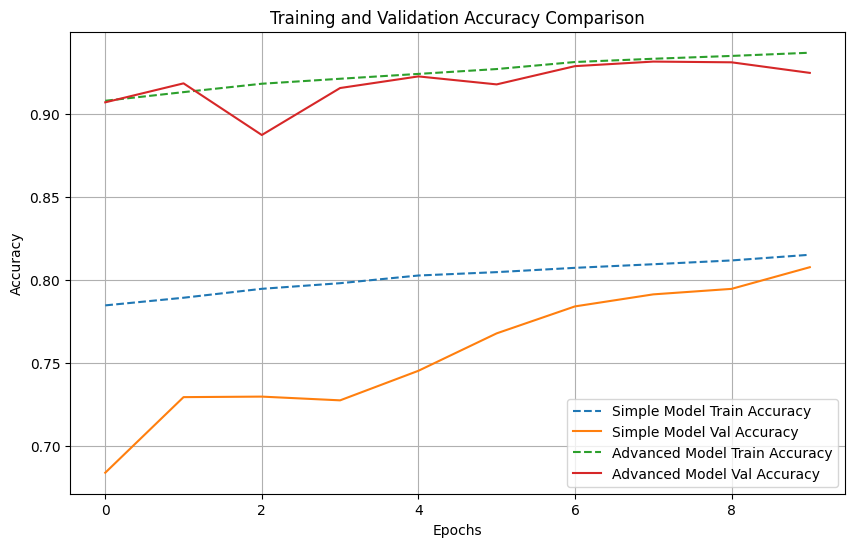

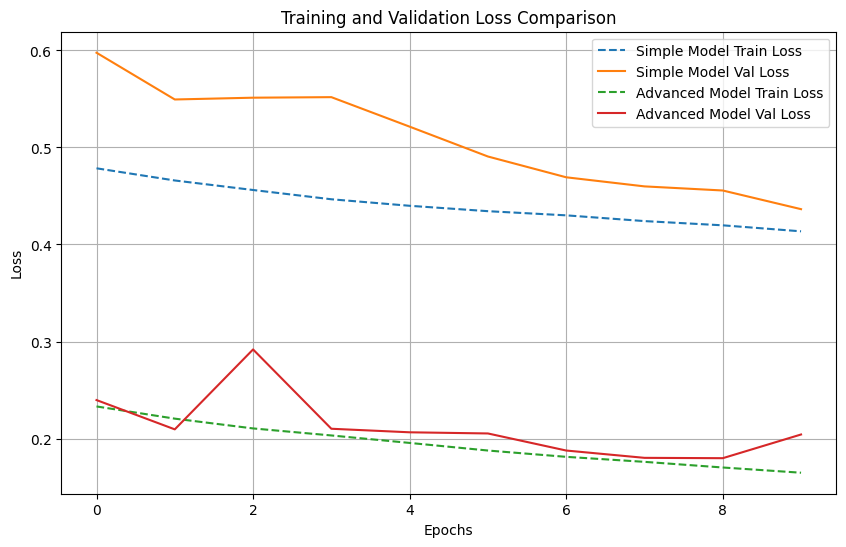

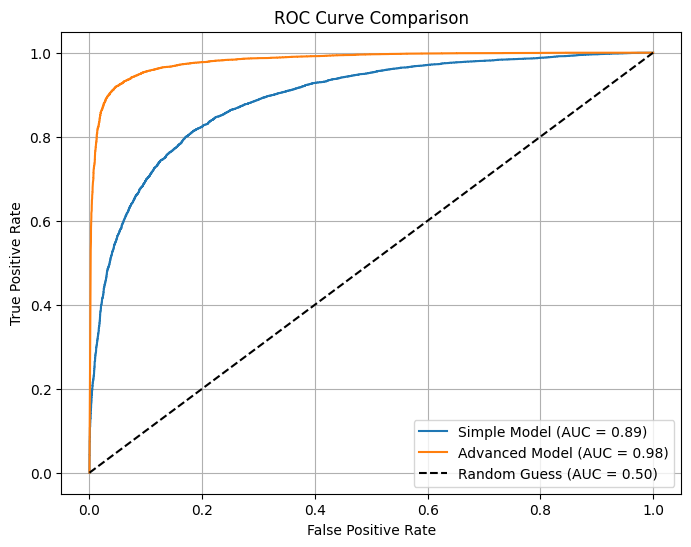

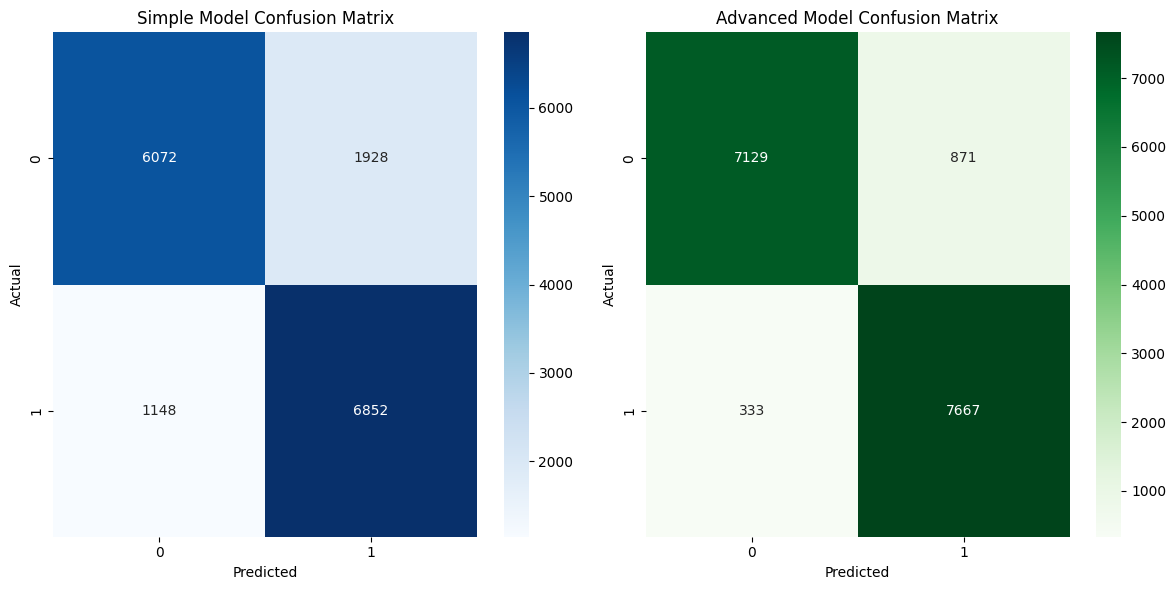

Simple Model: Training Time = 1292.93s, Prediction Time = 36.32s
Advanced Model: Training Time = 1320.15s, Prediction Time = 36.49s


In [42]:
# Simple Model
history1, y_true1, y_pred1, y_pred_proba1, cm1, roc_data1, train_time1, predict_time1 = evaluate_model(
    model, train_gen, val_gen, test_gen, epochs=10
)

# Advanced Model
history2, y_true2, y_pred2, y_pred_proba2, cm2, roc_data2, train_time2, predict_time2 = evaluate_model(
    advanced_model, train_gen, val_gen, test_gen, epochs=10
)

# Plot Accuracy
plot_accuracy(history1, history2, model1_name="Simple Model", model2_name="Advanced Model")

# Plot Loss
plot_loss(history1, history2, model1_name="Simple Model", model2_name="Advanced Model")

# ROC Curve
plot_roc_curve(y_pred_proba1[:, 1], y_pred_proba2[:, 1], y_true1, model1_name="Simple Model", model2_name="Advanced Model")

# Confusion Matrices
plot_confusion_matrix(y_true1, y_pred1, y_pred2, model1_name="Simple Model", model2_name="Advanced Model")

# Print Training and Prediction Times
print(f"Simple Model: Training Time = {train_time1:.2f}s, Prediction Time = {predict_time1:.2f}s")
print(f"Advanced Model: Training Time = {train_time2:.2f}s, Prediction Time = {predict_time2:.2f}s")


## Analysis and Comparison
As expected, the model advanced model performed better than the simple model. This is not surprising, with the increased layers, and the increased convolution layer size, enabling the model connect larger areas of the image, after lower concultion layer sizes have mapped smaller regions.

## Learnings
Adding the right layers to the model leads to an increase in accuracy. We see this increase even when we added two convolution layers to the model. From the final test, where we compared a model with one Convolution layer to a model with nine, the difference in training time was miniscule, and the difference in prediction time was also insignificant.

## Future work
It'll be interesting to automate the process of expanding the model to see how accurate the prediction can get. Some things we could also try include
* Increasing the epoch during training
* Varying the number of Convolution layers in each block
* Adding other layers to smoothing/de-noise the output from each block

## TEST PREDICTION FOR KAGGLE SUBMISSION
Let's predict and submit to kaggle

In [ ]:
test_path ='dataset/test'

# Change test_gen to point to the actual test image path
test_gen = datagen.flow_from_directory(test_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=1,
                                        class_mode='categorical',
                                        shuffle=False)

num_test_images = 57458
predictions = model.predict(test_gen, steps=num_test_images, verbose=1)



In [ ]:
df_preds = pd.DataFrame(predictions, columns=['no_tumor_tissue', 'has_tumor_tissue'])
df_preds.head()
test_filenames = test_gen.filenames

# add the filenames to the dataframe
df_preds['file_names'] = test_filenames

def extract_id(x):
    # split into a list
    a = x.split('/')
    b = a[1].split('.')
    extracted_id = b[0]
    return extracted_id

df_preds['id'] = df_preds['file_names'].apply(extract_id)

y_pred = df_preds['has_tumor_tissue']
image_id = df_preds['id']

submission = pd.DataFrame({'id':image_id,
                           'label':y_pred,
                          }).set_index('id')
submission.to_csv('submission.csv', columns=['label'])
submission.info()
submission.head()

In [ ]:
#!kaggle competitions submit -c histopathologic-cancer-detection -f submission.csv -m "Message"